In [11]:
import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor

from keras.layers import Embedding, Input, Dense
from keras.models import Model
import keras
import keras.backend as K
import tensorflow as tf
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt

In [12]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

def plot_actual_predicted(actual, predicted):
    print('RMSE: ', RMSLE(actual, predicted))
    tmp = pd.DataFrame({'actual': actual, 'predicted': predicted}).sort_values(['actual'])
    plt.scatter(range(tmp.shape[0]), tmp['predicted'], color='green')
    plt.scatter(range(tmp.shape[0]), tmp['actual'], color='blue')
    plt.show()
    del tmp

In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        print(e)

In [14]:
data = {
    'tra': pd.read_csv('air_visit_data.csv.zip'),
    'as': pd.read_csv('air_store_info.csv.zip'),
    'hs': pd.read_csv('hpg_store_info.csv.zip'),
    'ar': pd.read_csv('air_reserve.csv.zip'),
    'hr': pd.read_csv('hpg_reserve.csv.zip'),
    'id': pd.read_csv('store_id_relation.csv.zip'),
    'tes': pd.read_csv('sample_submission.csv.zip'),
    'hol': pd.read_csv('date_info.csv.zip').rename(columns={'calendar_date':'visit_date'})
    }

In [15]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

for df in ['ar','hr']:
    data[df]['reserve_visitors'] = np.log1p(data[df]['reserve_visitors'])
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_dow'] = data[df]['visit_datetime'].dt.dayofweek
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    # NEW FEATURE FROM aharless kernel
    data[df]['early_reservation'] = data[df]['reserve_datetime_diff'] > 2
    data[df]['late_reservation'] = data[df]['reserve_datetime_diff'] <= 2
    tmp1 = data[df][data[df]['early_reservation']].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df][data[df]['early_reservation']].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    tmp3 = data[df][data[df]['late_reservation']].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs12', 'reserve_visitors':'rv12'})
    tmp4 = data[df][data[df]['late_reservation']].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs22', 'reserve_visitors':'rv22'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])
    data[df] = pd.merge(data[df], tmp3, how='left', on=['air_store_id','visit_date'])
    data[df] = pd.merge(data[df], tmp4, how='left', on=['air_store_id','visit_date'])

In [16]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
# NEW FEATURE FROM aharless kernel
data['tra']['week'] = data['tra']['visit_date'].dt.weekday
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['week'] = data['tes']['visit_date'].dt.weekday
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

#sure it can be compressed...
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='inner', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

train['visitors'] = np.log1p(train['visitors'].values)

In [17]:
value_col = ['holiday_flg','min_visitors','mean_visitors','median_visitors','max_visitors','count_observations',
'rs1_x','rv1_x','rs2_x','rv2_x','rs1_y','rv1_y','rs2_y','rv2_y','total_reserv_sum','total_reserv_mean',
'total_reserv_dt_diff_mean','date_int','var_max_lat','var_max_long','lon_plus_lat']

nn_col = value_col + ['dow', 'year', 'month', 'air_store_id2', 'air_area_name', 'air_genre_name',
'air_area_name0', 'air_area_name1', 'air_area_name2', 'air_area_name3', 'air_area_name4',
'air_area_name5', 'air_area_name6', 'air_genre_name0', 'air_genre_name1',
'air_genre_name2', 'air_genre_name3', 'air_genre_name4']

X = train.copy()
X_test = test[nn_col].copy()

value_scaler = preprocessing.MinMaxScaler()
for vcol in value_col:
    X[vcol] = value_scaler.fit_transform(X[vcol].values.astype(np.float64).reshape(-1, 1))
    X_test[vcol] = value_scaler.transform(X_test[vcol].values.astype(np.float64).reshape(-1, 1))

X_train = list(X[nn_col].T.values)
Y_train = X['visitors'].values
nn_train = [X_train, Y_train]
nn_test = [list(X_test[nn_col].T.values)]
print("Train and test data prepared for NN")

Train and test data prepared for NN


In [18]:
def get_nn_complete_model(train, hidden1_neurons=35, hidden2_neurons=15):
    """
    Input:
        train:           train dataframe(used to define the input size of the embedding layer)
        hidden1_neurons: number of neurons in the first hidden layer
        hidden2_neurons: number of neurons in the first hidden layer
    Output:
        return 'keras neural network model'
    """
    K.clear_session()

    air_store_id = Input(shape=(1,), dtype='int32', name='air_store_id')
    air_store_id_emb = Embedding(len(train['air_store_id2'].unique()) + 1, 15, input_shape=(1,),
                                 name='air_store_id_emb')(air_store_id)
    air_store_id_emb = keras.layers.Flatten(name='air_store_id_emb_flatten')(air_store_id_emb)

    dow = Input(shape=(1,), dtype='int32', name='dow')
    dow_emb = Embedding(8, 3, input_shape=(1,), name='dow_emb')(dow)
    dow_emb = keras.layers.Flatten(name='dow_emb_flatten')(dow_emb)

    month = Input(shape=(1,), dtype='int32', name='month')
    month_emb = Embedding(13, 3, input_shape=(1,), name='month_emb')(month)
    month_emb = keras.layers.Flatten(name='month_emb_flatten')(month_emb)

    air_area_name, air_genre_name = [], []
    air_area_name_emb, air_genre_name_emb = [], []
    for i in range(7):
        area_name_col = 'air_area_name' + str(i)
        air_area_name.append(Input(shape=(1,), dtype='int32', name=area_name_col))
        tmp = Embedding(len(train[area_name_col].unique()), 3, input_shape=(1,),
                        name=area_name_col + '_emb')(air_area_name[-1])
        tmp = keras.layers.Flatten(name=area_name_col + '_emb_flatten')(tmp)
        air_area_name_emb.append(tmp)

        if i > 4:
            continue
        area_genre_col = 'air_genre_name' + str(i)
        air_genre_name.append(Input(shape=(1,), dtype='int32', name=area_genre_col))
        tmp = Embedding(len(train[area_genre_col].unique()), 3, input_shape=(1,),
                        name=area_genre_col + '_emb')(air_genre_name[-1])
        tmp = keras.layers.Flatten(name=area_genre_col + '_emb_flatten')(tmp)
        air_genre_name_emb.append(tmp)

    air_genre_name_emb = keras.layers.concatenate(air_genre_name_emb)
    air_genre_name_emb = Dense(4, activation='sigmoid', name='final_air_genre_emb')(air_genre_name_emb)

    air_area_name_emb = keras.layers.concatenate(air_area_name_emb)
    air_area_name_emb = Dense(4, activation='sigmoid', name='final_air_area_emb')(air_area_name_emb)
    
    air_area_code = Input(shape=(1,), dtype='int32', name='air_area_code')
    air_area_code_emb = Embedding(len(train['air_area_name'].unique()), 8, input_shape=(1,), name='air_area_code_emb')(air_area_code)
    air_area_code_emb = keras.layers.Flatten(name='air_area_code_emb_flatten')(air_area_code_emb)
    
    air_genre_code = Input(shape=(1,), dtype='int32', name='air_genre_code')
    air_genre_code_emb = Embedding(len(train['air_genre_name'].unique()), 5, input_shape=(1,),
                                   name='air_genre_code_emb')(air_genre_code)
    air_genre_code_emb = keras.layers.Flatten(name='air_genre_code_emb_flatten')(air_genre_code_emb)

    
    holiday_flg = Input(shape=(1,), dtype='float32', name='holiday_flg')
    year = Input(shape=(1,), dtype='float32', name='year')
    min_visitors = Input(shape=(1,), dtype='float32', name='min_visitors')
    mean_visitors = Input(shape=(1,), dtype='float32', name='mean_visitors')
    median_visitors = Input(shape=(1,), dtype='float32', name='median_visitors')
    max_visitors = Input(shape=(1,), dtype='float32', name='max_visitors')
    count_observations = Input(shape=(1,), dtype='float32', name='count_observations')
    rs1_x = Input(shape=(1,), dtype='float32', name='rs1_x')
    rv1_x = Input(shape=(1,), dtype='float32', name='rv1_x')
    rs2_x = Input(shape=(1,), dtype='float32', name='rs2_x')
    rv2_x = Input(shape=(1,), dtype='float32', name='rv2_x')
    rs1_y = Input(shape=(1,), dtype='float32', name='rs1_y')
    rv1_y = Input(shape=(1,), dtype='float32', name='rv1_y')
    rs2_y = Input(shape=(1,), dtype='float32', name='rs2_y')
    rv2_y = Input(shape=(1,), dtype='float32', name='rv2_y')
    total_reserv_sum = Input(shape=(1,), dtype='float32', name='total_reserv_sum')
    total_reserv_mean = Input(shape=(1,), dtype='float32', name='total_reserv_mean')
    total_reserv_dt_diff_mean = Input(shape=(1,), dtype='float32', name='total_reserv_dt_diff_mean')
    date_int = Input(shape=(1,), dtype='float32', name='date_int')
    var_max_lat = Input(shape=(1,), dtype='float32', name='var_max_lat')
    var_max_long = Input(shape=(1,), dtype='float32', name='var_max_long')
    lon_plus_lat = Input(shape=(1,), dtype='float32', name='lon_plus_lat')

    date_emb = keras.layers.concatenate([dow_emb, month_emb, year, holiday_flg])
    date_emb = Dense(5, activation='sigmoid', name='date_merged_emb')(date_emb)

    cat_layer = keras.layers.concatenate([holiday_flg, min_visitors, mean_visitors,
                    median_visitors, max_visitors, count_observations, rs1_x, rv1_x,
                    rs2_x, rv2_x, rs1_y, rv1_y, rs2_y, rv2_y,
                    total_reserv_sum, total_reserv_mean, total_reserv_dt_diff_mean,
                    date_int, var_max_lat, var_max_long, lon_plus_lat,
                    date_emb, air_area_name_emb, air_genre_name_emb,
                    air_area_code_emb, air_genre_code_emb, air_store_id_emb])

    m = Dense(hidden1_neurons, name='hidden1',
             kernel_initializer=keras.initializers.RandomNormal(mean=0.0,
                            stddev=0.05, seed=None))(cat_layer)
    m = keras.layers.LeakyReLU(alpha=0.2)(m)
    m = keras.layers.BatchNormalization()(m)
    
    m1 = Dense(hidden2_neurons, name='hidden2')(m)
    m1 = keras.layers.LeakyReLU(alpha=0.2)(m1)
    m = Dense(1, activation='relu')(m1)

    inp_ten = [
        holiday_flg, min_visitors, mean_visitors, median_visitors, max_visitors, count_observations,
        rs1_x, rv1_x, rs2_x, rv2_x, rs1_y, rv1_y, rs2_y, rv2_y, total_reserv_sum, total_reserv_mean,
        total_reserv_dt_diff_mean, date_int, var_max_lat, var_max_long, lon_plus_lat,
        dow, year, month, air_store_id, air_area_code, air_genre_code
    ]
    inp_ten += air_area_name
    inp_ten += air_genre_name
    model = Model(inp_ten, m)
    model.compile(loss='mse', optimizer='rmsprop', metrics=['acc'])

    return model

2023-05-07 09:06:56.531652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22290 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:43:00.0, compute capability: 8.6


Model1 trained
Model3 trained


2023-05-07 09:20:16.069147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-07 09:20:16.072787: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f8e0365e9f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-07 09:20:16.072804: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-05-07 09:20:16.076330: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-07 09:20:16.196022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-05-07 09:20:16.310723: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

Model4 trained
7828/7828 [==============================] - 28s 4ms/step
GradientBoostingRegressor:
RMSE:  0.36579706304968557


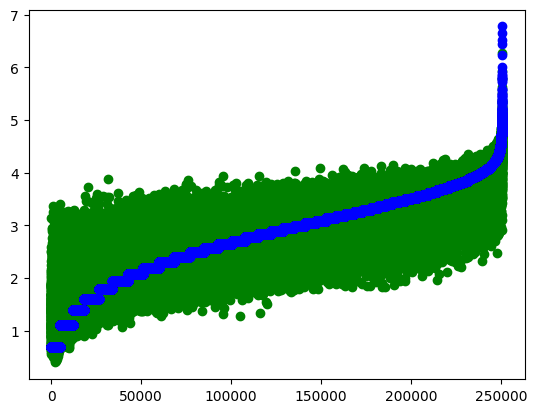

XGBRegressor:
RMSE:  0.33098600646714266


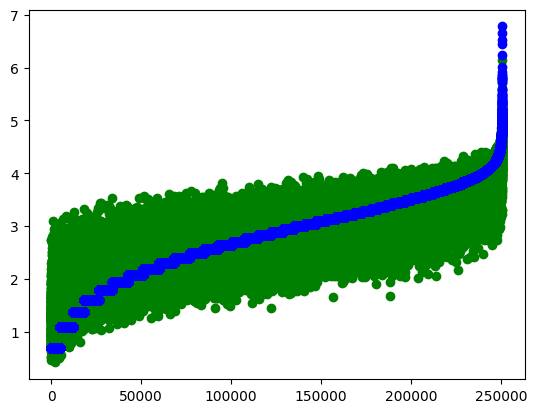

NeuralNetwork:
RMSE:  0.48417920454109414


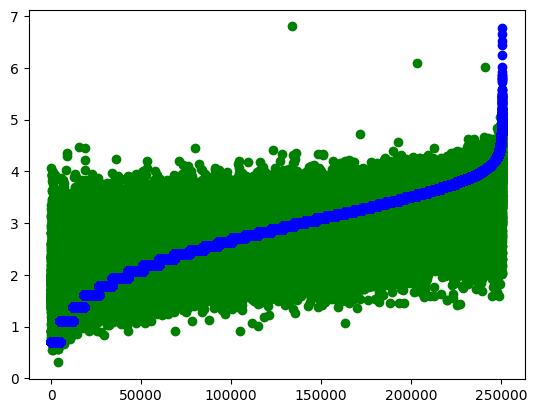

1001/1001 [==============================] - 4s 4ms/step
Model predictions done.


In [19]:
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3,
                    n_estimators=180, subsample=0.78, max_depth=10)
# model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
# model2 = ensemble.RandomForestRegressor(n_estimators=13, random_state=3, max_depth=18,
#                                         min_weight_fraction_leaf=0.0002)
model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=330, subsample=0.8, 
                      colsample_bytree=0.8, max_depth=10)
model4 = get_nn_complete_model(train, hidden1_neurons=45)

model1.fit(train[col], train['visitors'].values)
print("Model1 trained")

model3.fit(train[col], train['visitors'].values)
print("Model3 trained")

for i in range(5):
    model4.fit(nn_train[0], nn_train[1], epochs=8, verbose=0, batch_size=256, shuffle=True)
    model4.fit(nn_train[0], nn_train[1], epochs=3, verbose=0,
        batch_size=256, shuffle=True, validation_split=0.15)
model4.fit(nn_train[0], nn_train[1], epochs=4, verbose=0, batch_size=512, shuffle=True)
print("Model4 trained")

preds1 = model1.predict(train[col])
preds3 = model3.predict(train[col])
preds4 = pd.Series(model4.predict(nn_train[0]).reshape(-1)).clip(0, 6.8).values

actual_output = train['visitors'].values
print('GradientBoostingRegressor:')
plot_actual_predicted(actual_output, preds1)
print('XGBRegressor:')
plot_actual_predicted(actual_output, preds3)
print('NeuralNetwork:')
plot_actual_predicted(actual_output, preds4)

preds1 = model1.predict(test[col])
preds3 = model3.predict(test[col])
# .clip(0, 6.8) used to avoid random high values that might occur
preds4 = pd.Series(model4.predict(nn_test[0]).reshape(-1)).clip(0, 6.8).values

test['visitors'] = 0.2*preds1+0.4*preds3+0.4*preds4
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()
sub1['preds1'] = pd.Series(preds1)
sub1['preds3'] = pd.Series(preds3)
sub1['preds4'] = pd.Series(preds4)
print("Model predictions done.")
# del train; del data;

In [21]:
import os

dfs = {fn[:-8]:pd.read_csv(fn) for fn in os.listdir() if fn.endswith('.csv.zip')}

for k, v in dfs.items(): locals()[k] = v

wkend_holidays = date_info.apply(
    (lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  

visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)
visit_data['visitors'] = visit_data.visitors.map(np.log1p)

wmean = lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) # cumbersome, should be better ways.

sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['calendar_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission.drop('visitors', axis=1, inplace=True)
sample_submission = sample_submission.merge(date_info, on='calendar_date', how='left')
sample_submission = sample_submission.merge(visitors, on=[
    'air_store_id', 'day_of_week', 'holiday_flg'], how='left')

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), 
    how='left')['visitors_y'].values

sample_submission['visitors'] = sample_submission.visitors.map(np.expm1)
sub2 = sample_submission[['id', 'visitors']].copy()
sub2 = sub2.fillna(-1) # for the unfound values

In [22]:
def final_visitors(x, alt=False):
    visitors_x, visitors_y = x['visitors_x'], x['visitors_y']
    if x['visitors_y'] == -1:
        return visitors_x
    else:
        return 0.7*visitors_x + 0.3*visitors_y* 1.1

sub_merge = pd.merge(sub1, sub2, on='id', how='inner')
sub_merge['visitors'] = sub_merge.apply(lambda x: final_visitors(x), axis=1)
print("Done")
sub_merge[['id', 'visitors']].to_csv('submission.csv', index=False)


Done


In [23]:
sub_merge.head()

,id,visitors_x,preds1,preds3,preds4,visitors_y,visitors
0,air_00a91d42b08b08d9_2017-04-23,2.500443,1.188985,1.326321,1.211409,2.000000,2.410310
1,air_00a91d42b08b08d9_2017-04-24,18.890366,2.875070,2.973490,3.064564,23.621632,21.018395
2,air_00a91d42b08b08d9_2017-04-25,29.610182,3.402508,3.597977,3.254101,26.823130,29.578760
3,air_00a91d42b08b08d9_2017-04-26,23.852635,3.132875,2.982011,3.483960,27.600920,25.805148
4,air_00a91d42b08b08d9_2017-04-27,29.682963,3.362188,3.352999,3.525176,31.299646,31.106958


In [24]:
GBR = sub_merge[['id', 'preds1']]
GBR = GBR.rename(columns = {"preds1" : "visitors"})
GBR.to_csv('GradientBoostingRegressor.csv', index=False)
XGB = sub_merge[['id', 'preds3']]
XGB = XGB.rename(columns = {"preds3" : "visitors"})
XGB.to_csv('XGBRegressor.csv', index=False)
NN = sub_merge[['id', 'preds4']]
NN = NN.rename(columns = {"preds4" : "visitors"})
NN.to_csv('NeuralNetwork.csv', index=False)

In [32]:
from keras.models import Sequential
model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dow (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 month (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 air_area_name0 (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 air_area_name1 (InputLayer)    [(None, 1)]          0           []                               
                                                                                              